In [6]:
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=vIWvJCpOVmwU
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#from scipy.optimize import minimize
#from scipy import optimize
import pickle
#import statsmodels.api as sm
from math import ceil

from google.colab import drive
drive.mount("/content/drive")


from importlib import reload
import sys
sys.path.append('/content/drive/My Drive/ISE599Project_Phebe/Model')

import generate_dataset
import lstm_encoder_decoder
# import plotting 

Mounted at /content/drive


In [13]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        return out

        # divide a long sequence into small pieces
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


def plot_train_test_results(lstm_model, Xtrain, Ytrain, Xtest, Ytest, num_rows = 3):
  '''
  plot examples of the lstm encoder-decoder evaluated on the training/test data
  
  : param lstm_model:     trained lstm encoder-decoder
  : param Xtrain:         np.array of windowed training input data
  : param Ytrain:         np.array of windowed training target data
  : param Xtest:          np.array of windowed test input data
  : param Ytest:          np.array of windowed test target data 
  : param num_rows:       number of training/test examples to plot
  : return:               num_rows x 2 plots; first column is training data predictions,
  :                       second column is test data predictions
  '''

  # input window size
  iw = Xtrain.shape[0]
  ow = Ytest.shape[0]

  # figure setup 
  num_cols = 2
  num_plots = num_rows * num_cols

  fig, ax = plt.subplots(num_rows, num_cols, figsize = (13, 15))
  
  # plot training/test predictions
  for ii in range(num_rows):
      # train set
      X_train_plt = Xtrain[:, ii, :]
      Y_train_pred = lstm_model.predict(torch.from_numpy(X_train_plt).type(torch.Tensor), target_len = ow)

      ax[ii, 0].plot(np.arange(0, iw), Xtrain[:, ii+ow, 0], 'k', linewidth = 2, label = 'Input')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, ii+ow, 0]], Ytrain[:, ii+ow, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[Xtrain[-1, ii+ow, 0]], Y_train_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
      ax[ii, 0].set_xlim([0, iw + ow - 1])
      ax[ii, 0].set_xlabel('$t$')
      ax[ii, 0].set_ylabel('$y$')

      # test set
      X_test_plt = Xtest[:, ii, :]
      Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
      ax[ii, 1].plot(np.arange(0, iw), Xtest[:, ii+ow, 0], 'k', linewidth = 2, label = 'Input')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii+ow, 0]], Ytest[:, ii+ow, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii+ow, 0]], Y_test_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
      ax[ii, 1].set_xlim([0, iw + ow - 1])
      ax[ii, 1].set_xlabel('$t$')
      ax[ii, 1].set_ylabel('$y$')

      if ii == 0:
        ax[ii, 0].set_title('Train')
        
        ax[ii, 1].legend(bbox_to_anchor=(1, 1))
        ax[ii, 1].set_title('Test')

  plt.suptitle('LSTM Encoder-Decoder Predictions', x = 0.445, y = 1.)
  plt.tight_layout()
  plt.subplots_adjust(top = 0.95)
  # plt.savefig('plots/predictions.png')
  # plt.close() 
  

In [14]:
district_data = pd.read_csv('/content/drive/My Drive/ISE599Project_Phebe/Data/hospitalization_data_nolbandpasa.csv',header=None)
daily_cases = district_data.iloc[:, 0]
daily_cases

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
       ...  
655    105.0
656    106.0
657    107.0
658    112.0
659    110.0
Name: 0, Length: 660, dtype: float64

In [15]:
test_data_size = 250
train_data_size = 200
len_train = 30
forecast_len = 30 

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data = np.expand_dims(train_data, axis=1)
test_data = np.expand_dims(test_data, axis=1)

scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [16]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [17]:
seq_length = len_train 

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [18]:
num_epochs = 10000
learning_rate = 0.02

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.SmoothL1Loss(beta = 1)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
old_loss = 999999
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(X_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    #print(outputs.shape)
    loss = criterion(outputs, y_train)
    #print(loss)
    #if loss<=15000:
    #    break
    old_loss = loss
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.56413
Epoch: 100, loss: 0.00144
Epoch: 200, loss: 0.00054
Epoch: 300, loss: 0.00029
Epoch: 400, loss: 0.00020
Epoch: 500, loss: 0.00015
Epoch: 600, loss: 0.00012
Epoch: 700, loss: 0.00009
Epoch: 800, loss: 0.00008
Epoch: 900, loss: 0.00007
Epoch: 1000, loss: 0.00007
Epoch: 1100, loss: 0.00007
Epoch: 1200, loss: 0.00006
Epoch: 1300, loss: 0.00006
Epoch: 1400, loss: 0.00006
Epoch: 1500, loss: 0.00006
Epoch: 1600, loss: 0.00006
Epoch: 1700, loss: 0.00006
Epoch: 1800, loss: 0.00006
Epoch: 1900, loss: 0.00006
Epoch: 2000, loss: 0.00006
Epoch: 2100, loss: 0.00006
Epoch: 2200, loss: 0.00006
Epoch: 2300, loss: 0.00006
Epoch: 2400, loss: 0.00006
Epoch: 2500, loss: 0.00006
Epoch: 2600, loss: 0.00006
Epoch: 2700, loss: 0.00006
Epoch: 2800, loss: 0.00006
Epoch: 2900, loss: 0.00006
Epoch: 3000, loss: 0.00006
Epoch: 3100, loss: 0.00006
Epoch: 3200, loss: 0.00006
Epoch: 3300, loss: 0.00006
Epoch: 3400, loss: 0.00006
Epoch: 3500, loss: 0.00006
Epoch: 3600, loss: 0.00006
Epoch: 3700, 

In [19]:
def LSTM_pred(X,fc_len,train_len):
    input_ = X[0].reshape((1,train_len,1))
    preds = np.zeros((fc_len,1))
    for i in range(fc_len):
        preds[i,0] = lstm(input_.float())
        input_ = torch.cat((input_[0,1:len_train,0],torch.tensor(np.array([preds[i,0]])))).reshape((1,len_train,1))
    return preds

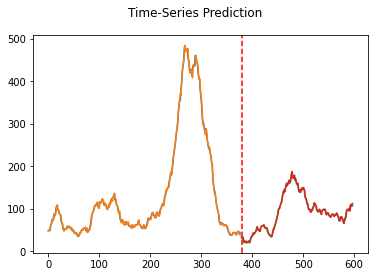

In [21]:
lstm.eval()
train_predict = lstm(X_train)

data_predict = train_predict.data.numpy()
dataY_plot = y_train.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=len(X_train), c='r', linestyle='--')

test_predict = lstm(X_test)
data_predict2 = test_predict.data.numpy()
dataY_plot2 = y_test.data.numpy()

data_predict2 = scaler.inverse_transform(data_predict2)
dataY_plot2 = scaler.inverse_transform(dataY_plot2)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),dataY_plot2)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict2)
plt.suptitle('Time-Series Prediction')
plt.show()

Conformal Prediction - Exchangability Preserved Version

In [22]:
#Create testing sequence
y_true = y_train.data.numpy()
y_calb = np.zeros((len(y_true)-forecast_len,forecast_len))
for i in range(len(y_true)-forecast_len):
    y_calb[i] = y_true[i:i+forecast_len].reshape(forecast_len,)

In [23]:
def find(x,alpha,data_len,fclen):
    idx = ceil((data_len+1)*((1)-alpha))
    return np.sort(np.array(x))[idx-1]

In [24]:
def CFLSTM(X,fclen,train_len,alpha):
    for i in range(fclen): #initalize epsilon
        globals()['eps%s' % i] = [] 
    y_pred = np.zeros((len(X)-fclen,fclen))
    for i in range(len(X)-fclen):
        y_pred[i] = LSTM_pred(X[i].reshape((1,train_len,1)),fclen,train_len).reshape(fclen,)
        for j in range(fclen):
            globals()['eps%s' % j].append(abs(y_pred[i,j]-y_calb[i,j]))
    #print(eps0)
    #Bonferroni and finite sample correction
    output = np.zeros(fclen)
    for t in range(fclen):
        output[t] = find(globals()['eps%s' % t],alpha,len(y_pred)-fclen,fclen)
    return output

In [25]:
epshtrain = CFLSTM(X_train,forecast_len,len_train,0.025)

In [26]:
rps  = epshtrain.reshape((forecast_len,1))

In [ ]:
lstm.eval()
train_predict = lstm(X_train)



data_predict = train_predict.data.numpy()
dataY_plot = y_train.data.numpy()


data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=len(X_train), c='b', linestyle='--')
plt.axvline(x=len(X_train)+30, c='b', linestyle='--')
plt.axvline(x=len(X_train)+60, c='b', linestyle='--')
plt.axvline(x=len(X_train)+90, c='b', linestyle='--')
plt.axvline(x=len(X_train)+120, c='b', linestyle='--')
plt.axvline(x=len(X_train)+150, c='b', linestyle='--')
plt.axvline(x=len(X_train)+180, c='b', linestyle='--')
plt.axvline(x=len(X_train)+210, c='b', linestyle='--')

input_ = X_test[0].reshape((1,len_train,1))
preds = np.zeros((len(X_test),1))
predsl = np.zeros((len(X_test),1))
predsu = np.zeros((len(X_test),1))
for i in range(len(X_test)):
    if i%forecast_len == 0: # make monthly predictions. 
        input_ = X_test[i].reshape((1,len_train,1)) 
    preds[i,0] = lstm(input_.float())
    predsl[i,0] = max(preds[i,0] - rps[i%forecast_len][0],0)
    predsu[i,0] = preds[i,0] + rps[i%forecast_len][0]
    input_ = torch.cat((input_[0,1:len_train,0],torch.tensor(np.array([preds[i,0]])))).reshape((1,len_train,1))
#test_predict = lstm(X_test)
#data_predict2 = test_predict.data.numpy()
#dataY_plot2 = y_test.data.numpy()

data_predict3 = scaler.inverse_transform(preds)
data_predict4 = scaler.inverse_transform(predsl)
data_predict5 = scaler.inverse_transform(predsu)
dataY_plot3 = scaler.inverse_transform(dataY_plot2)

#dataY_plot4 = scaler.inverse_transform(y_y)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),dataY_plot2)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict3)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict4)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict5)

plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
scaler.inverse_transform(rps)

In [ ]:
import datetime
Date = pd.unique(Loc1['ep_date'])
dates = [datetime.datetime.strptime(ts, "%m/%d/%Y") for ts in Date]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%m/%d/%Y") for ts in dates]
print("This data set contains data from",sorteddates[1],"to",sorteddates[-1])

This data set contains data from 03/02/2020 to 03/03/2022


There were duplicate results at the same place and day. 

In [ ]:
Loc1 = DF.loc[DF['geo_merge'] ==Location[1]] # data filtered for one location
values, counts = np.unique(Loc1['ep_date'], return_counts=True)
data = {'value' : values,
        'counts' : counts}
# Check whether there is duplicate data
UniqueData = pd.DataFrame(data)
UniqueData

,value,counts
0,1/1/2021,1
1,1/1/2022,1
2,1/10/2021,1
3,1/10/2022,1
4,1/11/2021,1
...,...,...
728,9/7/2021,1
729,9/8/2020,1
730,9/8/2021,1
731,9/9/2020,1


In [ ]:
# test for how to combine data of one day
A = Loc1.loc[Loc1['ep_date'] =="1/1/2022", 'hosp_14day'].sum()
B = Loc1.loc[Loc1['ep_date'] ==UniqueData.value[1], 'hosp_14day'].sum()
Loc1.loc[Loc1['ep_date'] ==UniqueData.value[1],]


,Unnamed: 0,ep_date,geo_merge,hosp_14day,hosp_14day_rate,adj_hosp_14day_rate,hosp_rate_unstable,population,zip0,zip1,...,zip10,pop65,pop,med_income,mean_income,male,white,black,asian,hispanic
20192,20193,1/1/2022,Alhambra,23,27,21,NaN,86724,91801.0,91803.0,...,0.0,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0


In [ ]:
Loc1_Sum = []
Loc1_date = []
for i in range(UniqueData.shape[0]):    
    Loc1_Sum.append(Loc1.loc[Loc1['ep_date'] ==UniqueData.value[i], 'hosp_14day'].sum())
    Loc1_date.append(UniqueData.value[i])

d = {'ep_date':Loc1_date,
     'hosp_14day':Loc1_Sum}
Loc1S = pd.DataFrame(data = d)
  

Loc1S['ep_date'] = pd.to_datetime(Loc1S['ep_date'])


In [ ]:
Loc1S = Loc1S.sort_values(by='ep_date')
Loc1S.index = range(len(Loc1S))
Loc1S
# # set the index to be the date
# Loc1S['ep_date'] = pd.to_datetime(Loc1S['ep_date'] )
# Loc1S = Loc1S.set_index('ep_date')

,ep_date,hosp_14day
0,2020-03-01,0
1,2020-03-02,0
2,2020-03-03,0
3,2020-03-04,0
4,2020-03-05,0
...,...,...
728,2022-02-27,6
729,2022-02-28,5
730,2022-03-01,5
731,2022-03-02,3


In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

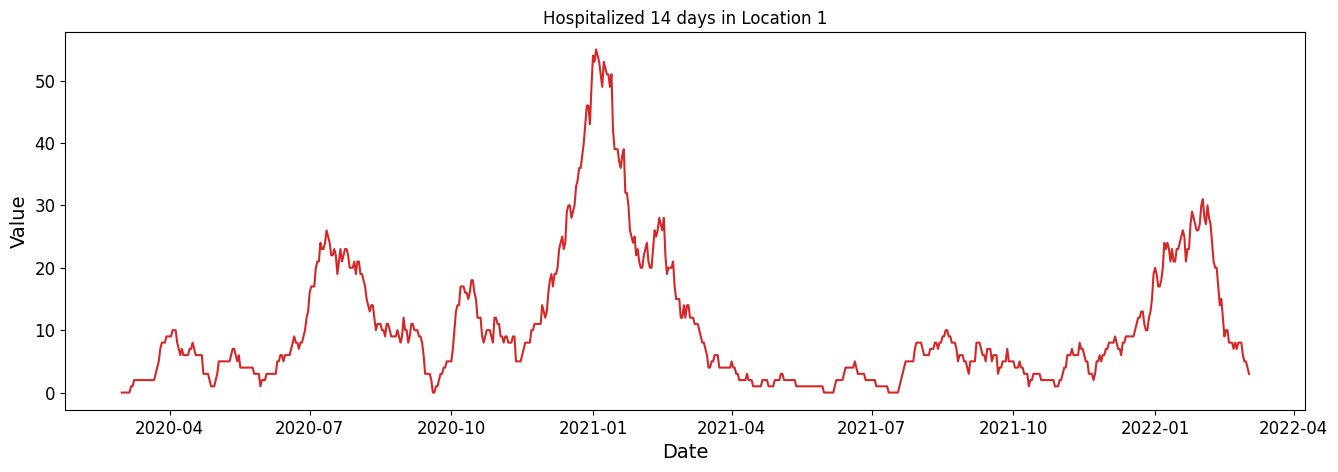

In [ ]:
plot_df(Loc1S, x=Loc1S.ep_date, y=Loc1S.hosp_14day, title='Hospitalized 14 days in Location 1')    

In [ ]:
Loc1 = DF.loc[DF['geo_merge'] ==Location[1]]
Loc1_Sum = []
Loc1_date = []
UniqueData = np.unique(Loc1['ep_date'])
for i in range(UniqueData.shape[0]):    
    Loc1_Sum.append(Loc1.loc[Loc1['ep_date'] ==UniqueData[i], 'hosp_14day'].sum())
    Loc1_date.append(UniqueData[i])

d = {'ep_date':Loc1_date,
     'hosp_14day':Loc1_Sum}
Loc1S = pd.DataFrame(data = d)

Loc1S['ep_date'] = pd.to_datetime(Loc1S['ep_date'])
Loc1S = Loc1S.sort_values(by='ep_date')
Loc1S.index = range(len(Loc1S))
Loc1S
# def organize_time_series(batch_size, n_steps):
#     freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
#     time = np.linspace(0, 1, n_steps)
#     series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
#     series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
#     series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
#     return series[..., np.newaxis].astype(np.float32)

,ep_date,hosp_14day
0,2020-03-01,0
1,2020-03-02,0
2,2020-03-03,0
3,2020-03-04,0
4,2020-03-05,0
...,...,...
728,2022-02-27,6
729,2022-02-28,5
730,2022-03-01,5
731,2022-03-02,3


In [ ]:
def organize_hos_ts(loc_index, DF, Location):
  Loc1 = DF.loc[DF['geo_merge'] ==Location[loc_index]]
  Loc1_Sum = []
  Loc1_date = []
  UniqueData = np.unique(Loc1['ep_date'])
  for i in range(UniqueData.shape[0]):    
    Loc1_Sum.append(Loc1.loc[Loc1['ep_date'] ==UniqueData[i], 'hosp_14day'].sum())
    Loc1_date.append(UniqueData[i])
    
  d = {'ep_date':Loc1_date,
       'hosp_14day':Loc1_Sum}
  Loc1S = pd.DataFrame(data = d)
  Loc1S['ep_date'] = pd.to_datetime(Loc1S['ep_date'])
  Loc1S = Loc1S.sort_values(by='ep_date')
  Loc1S.index = range(len(Loc1S))
  return Loc1S


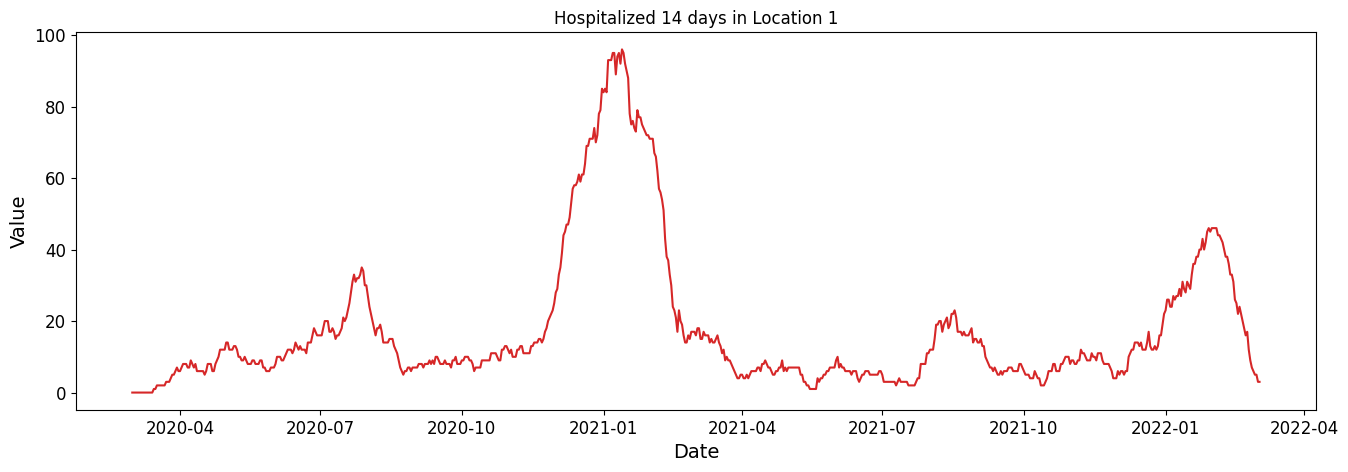

In [ ]:
df1 = organize_hos_ts(1, DF, Location)
plot_df(df1, x=df1.ep_date, y=df1.hosp_14day, title='Hospitalized 14 days in Location 1')    

In [ ]:
A = []
for i in range(50):
  df = organize_hos_ts(i, DF, Location)
  a = df['hosp_14day'].values
  A = np.append(A,a)
Hos_data = A.reshape(50,l)

In [ ]:
Hos_data = Hos_data[..., np.newaxis].astype(np.float32)

Basic RNN

In [ ]:
Nsample = Hos_data.shape[0]
Nlength = Hos_data.shape[1]
n_steps = 500
n_predict = Nlength - n_steps
Ntrian = int(Nsample * 0.7)
Nvalid = int(Nsample * 0.2)
Ntest = int(Nsample * 0.1)

X_train, y_train = Hos_data[:Ntrian, :n_steps], Hos_data[:Ntrian, -n_predict]
X_valid, y_valid = Hos_data[Ntrian:(Ntrian+Nvalid), :n_steps], Hos_data[Ntrian:(Ntrian+Nvalid), -n_predict]
X_test, Y_test = Hos_data[(Nsample - Ntest):, :n_steps], Hos_data[(Nsample - Ntest):, -n_predict]

Saving figure time_series_plot


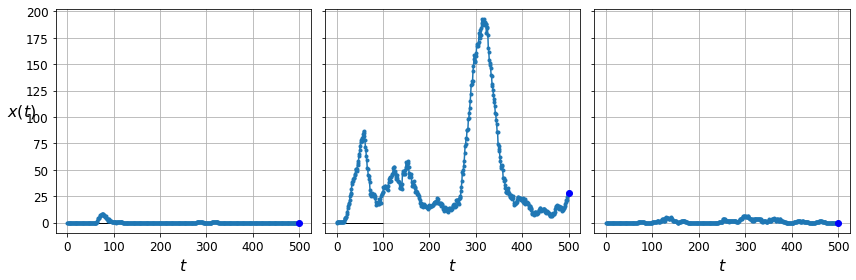

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    # plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


In [ ]:
X_valid.shape,Y_valid.shape

((10, 500, 1), (10, 500, 10))

In [ ]:
Y = np.empty((50, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = Hos_data[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:Ntrian]
Y_valid = Y[Ntrian:(Ntrian+Nvalid)]
Y_test = Y[(Nsample - Ntest):]

In [ ]:
X_train.shape, Y_train.shape

((35, 500, 1), (35, 500, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
2/2 [==============================] - 3s 572ms/step - loss: 1197.8785 - last_time_step_mse: 105.3992 - val_loss: 988.7826 - val_last_time_step_mse: 158.3761
Epoch 2/20
2/2 [==============================] - 0s 221ms/step - loss: 1176.3995 - last_time_step_mse: 98.6885 - val_loss: 976.1105 - val_last_time_step_mse: 152.5244
Epoch 3/20
2/2 [==============================] - 0s 218ms/step - loss: 1160.6400 - last_time_step_mse: 93.9659 - val_loss: 965.3958 - val_last_time_step_mse: 147.5046
Epoch 4/20
2/2 [==============================] - 0s 210ms/step - loss: 1147.2428 - last_time_step_mse: 90.0802 - val_loss: 955.5964 - val_last_time_step_mse: 142.9969
Epoch 5/20
2/2 [==============================] - 0s 230ms/step - loss: 1135.7430 - last_time_step_mse: 86.6742 - val_loss: 946.3856 - val_last_time_step_mse: 138.8399
Epoch 6/20
2/2 [==============================] - 0s 228ms/step - loss: 1124.0801 - last_time_step_mse: 83.3650 - val_loss: 937.2252 - val_last_time_step_mse: 

In [ ]:
X_new, Y_new = Hos_data[(Nsample - Ntest):,:n_steps,:], Hos_data[(Nsample - Ntest):,n_steps:(n_steps+10),:]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
Hos_data.shape,X_new.shape, Y_new.shape, Y_pred.shape

((50, 733, 1), (5, 500, 1), (5, 10, 1), (5, 10, 1))

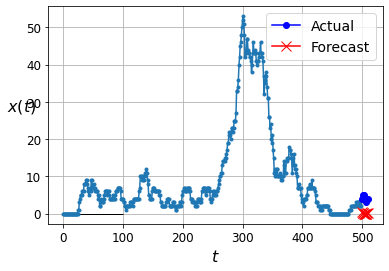

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

LSTM

In [ ]:
Nsample = Hos_data.shape[0]
Nlength = Hos_data.shape[1]
n_steps = 500
n_predict = Nlength - n_steps

X_train, y_train = Hos_data[1, :n_steps], Hos_data[1, -n_predict]
X_valid, y_valid = Hos_data[1, n_steps:(n_steps+100)], Hos_data[1, -n_predict]

Y = np.empty((1, n_stepszxzZ, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = Hos_data[1, step_ahead:(step_ahead + n_steps), 0]
Y_train = Y[:Ntrian]
Y_valid = Y[Ntrian:(Ntrian+Nvalid)]
Y_test = Y[(Nsample - Ntest):]

Y.shape,X_train.shape


NameError: ignored

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=50)

ValueError: ignored

In [ ]:
model.evaluate(X_valid, Y_valid)

1/1 [==============================] - 0s 115ms/step - loss: 847.9450 - last_time_step_mse: 95.9357


[847.9450073242188, 95.93572235107422]